<a href="https://colab.research.google.com/github/yuki-2025/LLM_distillation/blob/main/Distilling_Bert_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_pretrained_bert pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

As before, I’ll use torchnlp to load the data and the excellent PyTorch-Pretrained-BERT to build the model.

In [ ]:
%matplotlib inline
import sys
import itertools
import numpy as np
import random as rn
import matplotlib.pyplot as plt
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
from torchnlp.datasets import imdb_dataset
from pytorch_pretrained_bert import BertTokenizer
# from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

from keras import *

import tensorflow as tf

In [ ]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Prepare the Data

### There are 25,000 reviews in the train set, we’ll use only 1000 as a labeled set and another 5,000 as an unlabeled set (I also choose only 1000 reviews from the test set to speed things up):


In [ ]:
train_data_full, test_data_full = imdb_dataset(train=True, test=True) #imdb 是default dataset
rn.shuffle(train_data_full) #弄乱
rn.shuffle(test_data_full)
train_data = train_data_full[:1000] #选1000 Y-label
test_data = test_data_full[:1000]

aclImdb_v1.tar.gz: 84.1MB [00:16, 5.14MB/s]                            


In [ ]:
train_data[0]

{'text': 'Ah, true memories. I lived in Holland at the time and looked eagerly forward to it every Sunday evening and later Tuesdays. I saw it during my 14-16s. Very good for my (at the time school-)English, as Dutch TV provides subtitles for other languages, except for kiddies shows nowadays. So you would hear the original voices and language. - The best series were the first three ones and then after the third series, the great character, Nazi Von Gelb, who was such a formidable enemy, disappeared from the series (I don\'t think they ever really caught him, he always escaped, leaving room to have him appear again in a next story) because evidently the series also was distributed to Germany, and a Nazi enemy wouldn\'t go over very well! Too bad, because Geoffrey Toone did such a wonderful convincing job of portraying the intelligent Nazi aristocrat, who had this ongoing obsession to take revenge on England. It was a true delight to see this kind of high quality performance in a youth 

### The first thing we do is create a baseline using logistic regression:


In [ ]:
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data))) #分开 x 和 Y
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(1000, 1000, 1000, 1000)

In [ ]:
train_texts[0]

'Ah, true memories. I lived in Holland at the time and looked eagerly forward to it every Sunday evening and later Tuesdays. I saw it during my 14-16s. Very good for my (at the time school-)English, as Dutch TV provides subtitles for other languages, except for kiddies shows nowadays. So you would hear the original voices and language. - The best series were the first three ones and then after the third series, the great character, Nazi Von Gelb, who was such a formidable enemy, disappeared from the series (I don\'t think they ever really caught him, he always escaped, leaving room to have him appear again in a next story) because evidently the series also was distributed to Germany, and a Nazi enemy wouldn\'t go over very well! Too bad, because Geoffrey Toone did such a wonderful convincing job of portraying the intelligent Nazi aristocrat, who had this ongoing obsession to take revenge on England. It was a true delight to see this kind of high quality performance in a youth series, b

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 956237.24B/s]


In [ ]:
#tokenize x features 分割词 作为input，【CLS】是开头
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], test_texts))

len(train_tokens), len(test_tokens)

(1000, 1000)

In [ ]:
train_tokens[0]

['[CLS]',
 'ah',
 ',',
 'true',
 'memories',
 '.',
 'i',
 'lived',
 'in',
 'holland',
 'at',
 'the',
 'time',
 'and',
 'looked',
 'eagerly',
 'forward',
 'to',
 'it',
 'every',
 'sunday',
 'evening',
 'and',
 'later',
 'tuesday',
 '##s',
 '.',
 'i',
 'saw',
 'it',
 'during',
 'my',
 '14',
 '-',
 '16',
 '##s',
 '.',
 'very',
 'good',
 'for',
 'my',
 '(',
 'at',
 'the',
 'time',
 'school',
 '-',
 ')',
 'english',
 ',',
 'as',
 'dutch',
 'tv',
 'provides',
 'sub',
 '##titles',
 'for',
 'other',
 'languages',
 ',',
 'except',
 'for',
 'kidd',
 '##ies',
 'shows',
 'nowadays',
 '.',
 'so',
 'you',
 'would',
 'hear',
 'the',
 'original',
 'voices',
 'and',
 'language',
 '.',
 '-',
 'the',
 'best',
 'series',
 'were',
 'the',
 'first',
 'three',
 'ones',
 'and',
 'then',
 'after',
 'the',
 'third',
 'series',
 ',',
 'the',
 'great',
 'character',
 ',',
 'nazi',
 'von',
 'gel',
 '##b',
 ',',
 'who',
 'was',
 'such',
 'a',
 'formidable',
 'enemy',
 ',',
 'disappeared',
 'from',
 'the',
 'series'

In [ ]:
train_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, train_tokens)) #get每个token ID
test_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))

In [ ]:
train_tokens_ids =  tf.keras.utils.pad_sequences(train_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids =  tf.keras.utils.pad_sequences(test_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")
#The sequences of token IDs for both the training and test datasets are padded or truncated to a maximum length of 512.
#Padding is adding zeros to make all sequences the same length, which is required for batch processing in many deep learning
#frameworks. Truncation removes parts of the sequences that exceed the maximum length.
#Both operations ensure that the input tensor has a uniform shape.
#(token的长度填充+截断，
#一般都是tokenizer后变成model的input
#这里是只拿token id，别的（token_type_id, attention mask）都没有拿，[101]= CLS
train_tokens_ids.shape, test_tokens_ids.shape

((1000, 512), (1000, 512))

In [ ]:
train_tokens_ids

array([[  101,  6289,  1010, ...,     0,     0,     0],
       [  101,  2012,  2034, ...,     0,     0,     0],
       [  101,  2179,  2023, ...,     0,     0,     0],
       ...,
       [  101,  2074, 12489, ...,     0,     0,     0],
       [  101,  2023,  2003, ...,     0,     0,     0],
       [  101,  2387,  2023, ...,     0,     0,     0]])

In [ ]:
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)
#The training and test labels are converted into boolean arrays where 'pos' labels are mapped to True and all others to False.
#This suggests that it's a binary classification task with 'pos' likely standing for 'positive'.
#The output is the shape of the training and test datasets (which should be one-dimensional arrays of labels),
#the mean of the boolean arrays for the train and test datasets (which would give an idea of class balance),
#and the shapes of the train and test datasets.
#x做好了，现在做Y label, 本身是neg/pos的sentiment result， 转成array ，如果不是pos写

((1000,), (1000,), 0.489, 0.478)

In [ ]:
len( np.array(train_labels) == 'pos' )

1000

In [ ]:
train_y[0:100]

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False,  True, False,  True, False, False, False,
       False,  True, False,  True,  True,  True, False, False,  True,
       False, False, False,  True,  True,  True, False, False, False,
        True, False,  True, False,  True,  True,  True, False, False,
        True, False, False,  True,  True, False, False,  True,  True,
        True, False,  True,  True,  True,  True, False,  True, False,
        True, False,  True, False, False, False, False,  True, False,
        True, False,  True,  True,  True, False,  True, False,  True,
       False, False, False,  True,  True, False, False, False, False,
        True, False,  True,  True, False,  True, False,  True, False,
       False])

In [ ]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids] #每一个id都print出来找
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [ ]:
 for ii in train_tokens_ids[1:2] : print(ii) #positive就是0，其他的就是0 作为mask

[  101  2012  2034  1045  2134  1005  1056  2134  1005  1056  2066  2009
  2008  2172  1010  2348  1045  2106  1012  2027  2134  1005  1056  2421
  1996  2353  2995  3676  4245  1010  1996  2293  2090 27538  1998  7707
 14071  2015  1005  1056  2092  4541  1998  2070  5889  2020  2205  2367
  2013  2054  1045  2018  8078  1012  1026  7987  1013  1028  1026  7987
  1013  1028  2101  1045  3651  2008  1010  2018  1996  3185  2042  2062
  8884  2000  1996  2338  1010  2009  2052  2031  2042  2066  2274  2847
  2146  1010  1998  2052  2022  2785  1997  6945  6313  1012  2085  1045
  2066  2009  2200  2172  1010  2138  2026  8837  3494  2024  2045  2004
  1045  6533  2098  2068  1012 10254  2428  3504  2066  2019  4850  1999
  2444  1010  1998  2014  4955  2000  1996  2466  2012  1996 11693 11528
  2075  1997  1996  2143  2001 10392  1010  8884  1998  2460  1012  9465
  2485  2003 10768  6820  2721  1012  1045 15885  2014  2074  2066  2008
  1010  2069  2025  1999 16236  2802  1996  2878  2

# Baseline

create a baseline using logistic regression

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [ ]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)
## Train model and predict


In [ ]:
baseline_predicted = baseline_model.predict(test_texts)

In [ ]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

         neg       0.77      0.82      0.80       522
         pos       0.79      0.74      0.76       478

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



We get not so great results

# BERT model

Next step, is to fine-tune BERT, I will skip the code here, you can see it the notebook or a more detailed tutorial in my previous post. The result is a trained model called BertBinaryClassifier which uses BERT and then a linear layer to provide the pos/neg classification. The performance of this model is:

In [ ]:
#This class inherits from nn.Module, which is a base class for all neural network modules in PyTorch.
class BertBinaryClassifier(nn.Module): #建两个Model: bert和linear Regress
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(768, 1)
        #a linear layer that maps the BERT output (which is 768-dimensional) to a single value, as it's a binary classifier.

    #The forward method defines the forward pass for the input tokens and optional masks.
    #It retrieves the pooled output from the BERT model and applies the linear layer to it.
    #The pooled output is typically taken from the output of the BERT model's [CLS] token, which is used for classification tasks.

    #把bert的output 给linear
    def forward(self, tokens, masks=None):
        #效果=outputs = model(tokens_tensor, segments_tensors)
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        linear_output = self.linear(pooled_output)
        return linear_output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()
# 定gpu

100%|██████████| 407873900/407873900 [00:09<00:00, 45104671.76B/s]
/usr/local/lib/python3.11/dist-packages/pytorch_pretrained_bert/modeling.py:603: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

In [ ]:
BATCH_SIZE = 4
EPOCHS = 3

In [ ]:
# data111 = np.array([0, 1, 0, 1])

# data111 = array([[0],
#                  [1],
#                  [0],
#                  [1]])

In [ ]:
#Data Preparation:

train_tokens_tensor = torch.tensor(train_tokens_ids) # tensor
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float() # from 2D array to one column （-1 = 4个element自动4rows)

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks) #attention masks, which help the model distinguish between content and padding.
test_masks_tensor = torch.tensor(test_masks)

# 把y-label的tokenid,mask都放到tensor

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M' #CUDA memory allocated,

'439.065088M'

In [ ]:

# BATCH_SIZE = 4 -  during training, the model will process 4 examples at a time.
# EPOCHS = 3 -An epoch is a complete pass through the entire training dataset. pass3次
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
#dataset 打包tensor-要有tokenid,mask, actualdata(true false) 已经转成1column
train_sampler = RandomSampler(train_dataset)
#randomly shuffle the data, which helps in breaking any inherent ordering in the data that might affect the learning process.
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
#combines the dataset and the sampler and provides an iterable over the dataset.
#The DataLoader can load multiple samples parallelly using multi-threading, which is highly efficient.
#fetch batches of data with 4 samples per batch

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)


In [ ]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)
#An optimizer is created using the Adam algorithm, a common choice for training neural networks.
#The learning rate is set to 3e-6, which is quite small and typical for fine-tuning BERT models.

In [ ]:
loss_func = nn.BCEWithLogitsLoss().cuda()
# defining a loss function that is suitable for binary classification tasks, and it is preparing it to run on a CUDA-enabled GPU device.
# from PyTorch's neural networks module (torch.nn). BCEWithLogitsLoss stands for Binary Cross-Entropy with Logits Loss.

# This loss function combines a Sigmoid layer and the BCELoss (Binary Cross-Entropy Loss) in one single class.
# This means that it's designed to operate on raw scores from the last layer of your model (logits), and it internally
# applies the sigmoid activation function to these logits before calculating the actual binary cross-entropy loss.
#This is more numerically stable than using a plain Sigmoid followed by a BCELoss,
#which could result in problems due to the precision of floating-point calculations.

#.cuda(): This method transfers the loss function to the GPU, allowing the computation to be done on the GPU
# which is much faster for the operations PyTorch performs during backpropagation and gradient descent.

In [ ]:
for step_num, batch_data in enumerate(train_dataloader):
        display(tuple(t.to(device) for t in batch_data) )
        break
        #display(train_dataloader)

(tensor([[ 101, 4422, 9805,  ..., 2032, 1999, 3152],
         [ 101, 6655, 9515,  ...,    0,    0,    0],
         [ 101, 2205, 2919,  ...,    0,    0,    0],
         [ 101, 1000, 2577,  ...,    0,    0,    0]], device='cuda:0'),
 tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]], device='cuda:0'),
 tensor([[1.],
         [1.],
         [0.],
         [1.]], device='cuda:0'))

In [ ]:
losses = []
steps = []
step = 0
# 按batch输入data，train了bert之后，算predict和actual直接的loss/差距, batch_loss回传
# 清除gradient，把bert的parameter gradient max1，update model's weights

#fine-tuning a BERT model
for epoch_num in range(EPOCHS):
    #整个过程loop/eponch 3次，
    bert_clf.train() #This puts the model in training mode. Unlike evaluation mode
    #training mode allows for certain behaviors like dropout and batch normalization to work in the mode appropriate for training.
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        # #
        #     (tensor([[ 101, 1999, 2026,  ...,    0,    0,    0],
        #              [ 101, 2009, 2109,  ...,    0,    0,    0],
        #              [ 101, 1045, 2074,  ...,    0,    0,    0],
        #              [ 101, 2096, 1045,  ...,    0,    0,    0]], device='cuda:0'),
        #      tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        #              [1., 1., 1.,  ..., 0., 0., 0.],
        #              [1., 1., 1.,  ..., 0., 0., 0.],
        #              [1., 1., 1.,  ..., 0., 0., 0.]], device='cuda:0'),
        #      tensor([[1.],
        #              [0.],
        #              [1.],
        #              [0.]], device='cuda:0'))
        probas = bert_clf(token_ids, masks) #只放3个tensor的2个；train model之后得到prediction；
        # out = tensor([[0.1845],
        #[0.1592],
        #[0.0929],
        #[0.1595]], device='cuda:0', grad_fn=<AddmmBackward0>)

        # 'labels= '
        # tensor([[1.],
        #         [1.],
        #         [1.],
        #         [0.]], device='cuda:0')
        batch_loss = loss_func(probas, labels) #loss btw predicted probabilities and the actual labels.
        # tensor(0.6197, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
        train_loss += batch_loss.item() #取里面的0.6196919083595276

        bert_clf.zero_grad() #Before you calculate the gradients for a batch, you need to zero out the gradients from the previous batch.
        batch_loss.backward() # Performs gradient backpropagation
        #compute the gradient of the loss with respect to all parameters of the model that are trainable.
        #These gradients are used in the optimization step to update the parameters.

        #Clamps the gradients of the model parameters to a maximum norm of 1.0 to prevent exploding gradients (a common issue in deep learning).
        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step() #updates the model's weights

        #Prints out the progress of training and accumulates the loss for analysis.
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        #1000条data，batch_size是分4次做，一次是250条data，step_num=现在的batch num, avg_train_loss每次预测的差距，
        print("{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))
        losses.append(batch_loss.item())
        steps.append(step)
        step += 1

    display("train_data ",losses)
    display("steps ",steps)

Epoch:  3
249/250.0 loss: 0.270366348285228 


'train_data '

[0.7006343603134155,
 0.7020648717880249,
 0.6997123956680298,
 0.7282564640045166,
 0.6846250295639038,
 0.7019064426422119,
 0.7087236046791077,
 0.677876353263855,
 0.6960886716842651,
 0.6841288208961487,
 0.7058299779891968,
 0.6948597431182861,
 0.6736465692520142,
 0.7210195064544678,
 0.7062524557113647,
 0.6978850364685059,
 0.6875633001327515,
 0.6801782250404358,
 0.6990731954574585,
 0.6583489775657654,
 0.6718583106994629,
 0.7003213763237,
 0.7025057077407837,
 0.7000648975372314,
 0.6886208057403564,
 0.7167797684669495,
 0.6986459493637085,
 0.6721349358558655,
 0.7022879719734192,
 0.7047257423400879,
 0.6726834774017334,
 0.6649343967437744,
 0.6954067349433899,
 0.6947733759880066,
 0.6782194375991821,
 0.6913851499557495,
 0.7291110157966614,
 0.6666584014892578,
 0.7067966461181641,
 0.6540507674217224,
 0.6778818368911743,
 0.6558787822723389,
 0.6735067963600159,
 0.6855457425117493,
 0.7467573881149292,
 0.7210464477539062,
 0.6983645558357239,
 0.69647645950317

'steps '

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
#Defines the sigmoid activation function, which is used to map the logits (outputs of the linear layer before activation)
# to probabilities (between 0 and 1).

In [ ]:

bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        probas = bert_clf(token_ids, masks)
        numpy_probas = probas.cpu().detach().numpy()

        bert_predicted += list(sigmoid(numpy_probas[:, 0]) > 0.5)

In [ ]:
%%time
# 测试bert

bert_clf.eval() #The model is set to evaluation mode, which disables dropout layers and batch normalization during inference.

#For each batch, it computes the probabilities,
bert_predicted = []
all_logits = []
#It loops over the test_dataloader without computing gradients (torch.no_grad()) as it's not necessary during evaluation.
with torch.no_grad():

    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        probas = bert_clf(token_ids, masks)
        # result
        # tensor([[ 5.5060],
        # [-5.4293],
        # [-5.5896],
        # [ 5.4942]], device='cuda:0')
        numpy_probas = probas.cpu().detach().numpy()
        # converts tensor to a NumPy array,
           #  array([[ 5.5060115],
           # [-5.429266 ],
           # [-5.589601 ],
           # [ 5.494161 ]], dtype=float32)

        bert_predicted += list(sigmoid(numpy_probas[:, 0]) > 0.5)
        #bert_predicted += list(sigmoid(numpy_probas[:, 0]) )
        # applies the sigmoid function, and determines if the probability is greater than 0.5 to
        #  decide the predicted class. The results are accumulated into bert_predicted.

        # display(numpy_probas[:, 0]) #array([ True, False, False,  True]); 取all rows but 1st column；pivot column to row
        #display(sigmoid(numpy_probas[:, 0]) ) #array([0.99595416, 0.00436716, 0.00372261, 0.9959061 ], dtype=float32) #把predict btw(1,-1)
        # display(sigmoid(numpy_probas[:, 0]) > 0.5) #array([ True, False, False,  True]) 大于0.5的true
        # display(bert_predicted) # [True, False, False, True, False, True, True, True, True, True, False, False] 收集所有result

        # break


CPU times: user 40 s, sys: 62 ms, total: 40.1 s
Wall time: 40.2 s


In [ ]:
bert_predicted[:5]

[True, False, False, True, False]

In [ ]:
print(classification_report(test_y, bert_predicted))

              precision    recall  f1-score   support

       False       0.86      0.93      0.89       522
        True       0.91      0.83      0.87       478

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



Much much better! As I said — Magic :)

# Distilling BERT

In [ ]:
train_dataset_for_distill = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_dataloader_for_distill = DataLoader(train_dataset, batch_size=BATCH_SIZE)

In [ ]:
bert_clf.eval()
train_logits = []
with torch.no_grad():
    #tells PyTorch not to calculate gradients during the subsequent operations. This saves memory and computations
    for step_num, batch_data in enumerate(train_dataloader_for_distill):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        # tensor([[5.4904],
        # [5.5538],
        # [5.5504],
        # [5.5944]], device='cuda:0')
        numpy_logits = logits.cpu().detach().numpy() #tensor变成array

        train_logits.append(numpy_logits)
        # if step_num >2:
        #     display(train_logits)
        #     break
train_logits = np.vstack(train_logits)
# display(train_logits)

In [ ]:
print(classification_report(train_y, sigmoid(train_logits[:, 0]) > 0.5))

              precision    recall  f1-score   support

       False       0.98      0.97      0.98       511
        True       0.97      0.98      0.98       489

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [ ]:
train_logits[0:20]

array([[ 5.490407 ],
       [ 5.5537972],
       [ 5.5504026],
       [ 5.594379 ],
       [ 4.5321407],
       [ 5.232877 ],
       [ 5.3224754],
       [ 5.5728335],
       [-5.3254294],
       [-5.4204583],
       [-5.4548507],
       [-5.4243946],
       [ 5.3226986],
       [-5.4491897],
       [ 5.2757034],
       [-5.4687033],
       [-5.3475957],
       [-5.4602137],
       [-5.587367 ],
       [ 5.449318 ]], dtype=float32)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
distilled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(train_texts, train_logits)
#和一般的linear regression不一样的是把train_logits是bert预测好的给linear

In [ ]:
distilled_predicted_logits = distilled_model.predict(test_texts)

In [ ]:
print(classification_report(test_y, sigmoid(distilled_predicted_logits[:, 0]) > 0.5))

              precision    recall  f1-score   support

       False       0.84      0.76      0.80       522
        True       0.76      0.84      0.80       478

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



(array([496.,   5.,   3.,   2.,   4.,   0.,   1.,   2.,   4., 483.]),
 array([-5.63385344, -4.50565815, -3.37746334, -2.24926829, -1.12107325,
         0.0071218 ,  1.13531685,  2.2635119 ,  3.39170694,  4.51990223,
         5.64809704]),
 <BarContainer object of 10 artists>)

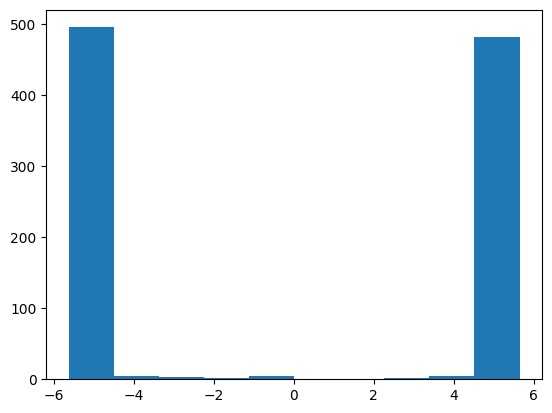

In [ ]:
plt.hist(train_logits)

*预测的结果*-5 到 5之间 ，之前是0和1

\
现在用其他的数据试
Now to the interesting part, we use the unlabeled set and “label” it using our fine-tuned BERT model:

In [ ]:
unlabeled_data = train_data_full[1000:6000] ## We use another 5000 reviews as unlabeled data


In [ ]:
unlabeled_texts, _ = list(zip(*map(lambda d: (d['text'], d['sentiment']), unlabeled_data))) #分开 x 和 Y ;Y = —_这里不要了，

In [ ]:
unlabeled_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], unlabeled_texts)) #tokenize

In [ ]:
unlabeled_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, unlabeled_tokens)) #找token id

In [ ]:
unlabeled_tokens_ids = tf.keras.utils.pad_sequences(unlabeled_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")
unlabeled_tokens_ids.shape #token的长度填充+截断，

(5000, 512)

In [ ]:
unlabeled_masks = [[float(i > 0) for i in ii] for ii in unlabeled_tokens_ids] #自己找 attention mask

In [ ]:
unlabeled_tokens_tensor = torch.tensor(unlabeled_tokens_ids) #把token id , attention mask 放到tensor
unlabeled_masks_tensor = torch.tensor(unlabeled_masks)

In [ ]:
## We "predict" the raw logits using the fine-tuned BERT model

unlabeled_dataset = TensorDataset(unlabeled_tokens_tensor, unlabeled_masks_tensor)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE)

In [ ]:
bert_clf.eval()
unlabeled_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(unlabeled_dataloader): #5000条，4batch，每次1250

        token_ids, masks = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()

        unlabeled_logits.append(numpy_logits)
        clear_output(wait=True)
        print("{0}/{1}".format(step_num, len(unlabeled_data) / BATCH_SIZE))
unlabeled_logits = np.vstack(unlabeled_logits)

1249/1250.0


In [ ]:
unlabeled_logits[0:20]

array([[-5.507926 ],
       [ 5.5109105],
       [ 5.5285363],
       [-4.888447 ],
       [-5.477286 ],
       [-5.290694 ],
       [-5.414143 ],
       [-5.471599 ],
       [ 5.6312623],
       [-5.184795 ],
       [ 5.363724 ],
       [-5.5648894],
       [-5.1566586],
       [ 5.502614 ],
       [-5.3328004],
       [ 5.4390597],
       [-5.3108563],
       [-5.573649 ],
       [-5.331365 ],
       [ 5.07082  ]], dtype=float32)

In [ ]:
unlabeled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(unlabeled_texts, unlabeled_logits)

In [ ]:
unlabele_predicted_logits = unlabeled_model.predict(test_texts)

In [ ]:
print(classification_report(test_y, sigmoid(unlabele_predicted_logits[:, 0]) > 0.5))

              precision    recall  f1-score   support

       False       0.87      0.84      0.85       522
        True       0.83      0.86      0.84       478

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



In [ ]:
Not as great as the original fine-tuned BERT, but it’s much better than the baseline! Now we are ready to deploy this small model to production and enjoy both good quality and inference speed.